# CLIP adversarial robustness

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torchvision.transforms

import clip

print("Torch version:", torch.__version__)
print(torch.cuda.get_device_name(0))

Torch version: 1.7.1
GeForce RTX 3080


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=DEVICE)
model.eval()
DEVICE

'cuda'

In [10]:
def get_logits(images, text):
    norm_images = torchvision.transforms.Normalize(mean=clip.NORM_MEAN, std=clip.NORM_STD)(images)
    logits_per_image, _ = model(norm_images, text)
    return logits_per_image

def get_probs(images, text):
    with torch.no_grad():
        logits = get_logits(images, text)
        probs = logits.softmax(dim=-1).cpu().numpy()
    return probs

In [5]:
def image_to_np(image):
    return (
        image
        .cpu()
        .numpy()
        .swapaxes(0, 1)
        .swapaxes(1, 2)
    )

### Sample run

In [59]:
%%time
labels = ["a hat", "a violin", "a chair"]

images = transform(Image.open("data/chair.png")).unsqueeze(0).to(DEVICE)
text = clip.tokenize(labels).to(DEVICE)
text.shape, images.shape, images.min(), images.max()

CPU times: user 15.8 ms, sys: 11.7 ms, total: 27.5 ms
Wall time: 4.47 ms


(torch.Size([3, 77]),
 torch.Size([1, 3, 224, 224]),
 tensor(0., device='cuda:0'),
 tensor(0.9255, device='cuda:0'))

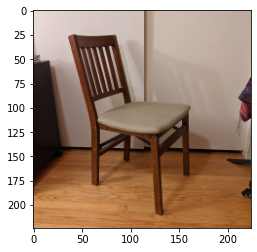

In [60]:
plt.imshow(image_to_np(images[0]));

In [61]:
%%time
print(labels)
print(get_probs(images, text))

['a hat', 'a violin', 'a chair']
[[3.82e-05 6.50e-05 1.00e+00]]
CPU times: user 26.6 ms, sys: 21 ms, total: 47.6 ms
Wall time: 84.4 ms


# Attacks

In [62]:
def pgd_linf(images, text, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    attack_images = images.clone().detach().requires_grad_()
    for t in range(num_iter):
        logits = get_logits(attack_images, text)
        obj = logits[:, 0].sum()  # want to maximize
        
        attack_images.grad = None
        obj.backward()
        
        with torch.no_grad():
            attack_images += alpha * attack_images.grad.sign()
            
            deltas = attack_images - images
            deltas = deltas.clamp(-epsilon, epsilon)
            attack_images = images + deltas
            
            attack_images = attack_images.clamp(0, 1)
        
        attack_images.requires_grad_()

    return attack_images.detach()

In [67]:
%%time
labels = ["a hat", "a violin", "a chair"]

images = transform(Image.open("data/chair.png")).unsqueeze(0).to(DEVICE)
text = clip.tokenize(labels).to(DEVICE)

linf_attack_images = pgd_linf(
    images=images,
    text=text,
    epsilon=0.01,
    alpha=0.001,
    num_iter=20,
)

CPU times: user 4.01 s, sys: 352 ms, total: 4.36 s
Wall time: 4.23 s


['a hat', 'a violin', 'a chair']
Orig probs: [[3.82e-05 6.50e-05 1.00e+00]]
Attack probs: [[9.556e-01 2.577e-04 4.401e-02]]
Max pixel dist: 0.010/1.0


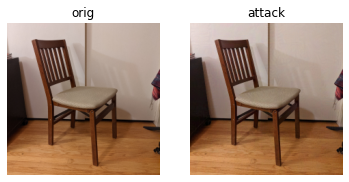

In [68]:
orig_np_img = image_to_np(images[0])
attack_np_img = image_to_np(linf_attack_images[0])

print(labels)
print("Orig probs:", get_probs(images, text))
print("Attack probs:", get_probs(linf_attack_images, text))
print(f"Max pixel dist: {np.abs(orig_np_img - attack_np_img).max():.3f}/1.0")

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(orig_np_img)
plt.title("orig");

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(attack_np_img)
plt.title("attack");